In [1]:
import mat73
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
import sys

In [2]:
sys.path.append(r'../utils/')

from mostrarDatos import visualizarPerfiles
from segmentarDatos import obtenerExperimento

In [4]:
data = mat73.loadmat(r'../datos/experimento3_sep.mat')

X = data["X"]
U = data["U"]
N = data["N"]

sizeExp = np.insert(data["N"],0,0).astype(int)
sizeExp = sizeExp[1:]

tm = 5e-3 # Tiempo de muestreo
Q = np.size(U,0) # Número de muestras
t = np.arange(0, Q*tm, tm) # Vector de tiempo

Para esta primera aproximación, se optará por emplear la SVD como técnica de reducción de la dimensión. Este algoritmo factoriza la matriz dada en $X = U \cdot \Sigma \cdot V^T$. Donde las columnas de $U$ y $V$ conforman bases ortonormalizadas del espacio en columnas y filas de $X$, respectivamente. Es preciso anotar que al ser X una matriz espacio-temporal, las matrices U y V son bases ortonormales referidas al espacio y al tiempo en el que se han desarrollado los experimentos.

In [5]:
[Ur, Sr, Vr] = np.linalg.svd(X, full_matrices=False)

cdS = np.cumsum(Sr) / np.sum(Sr) # Energía acumulada

# Método intuitivo
r = 14
Vr14 = Vr[:(r+1),:] # Matriz de cambio de base a espacio de baja dimensión
Xr14 = Ur[:,:(r+1)] @ np.diag(Sr[:(r+1)]) @ Vr[:(r+1),:]

# Optimal Hard Thresholding
beta = X.shape[1] / X.shape[0]
omega = 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43
threshold = omega * np.median(Sr) # Umbral óptimo

roptimal = np.argmin(np.abs(Sr - threshold))
print(f"Optimal rank r truncation: {roptimal}")

XrOpt = Ur[:,:(roptimal+1)] @ np.diag(Sr[:(roptimal+1)]) @ Vr[:(roptimal+1),:]

Optimal rank r truncation: 184


In [6]:
print(f"Dimensiones de la matriz de cambio de base : {Vr14.shape}")

Dimensiones de la matriz de cambio de base : (15, 500)


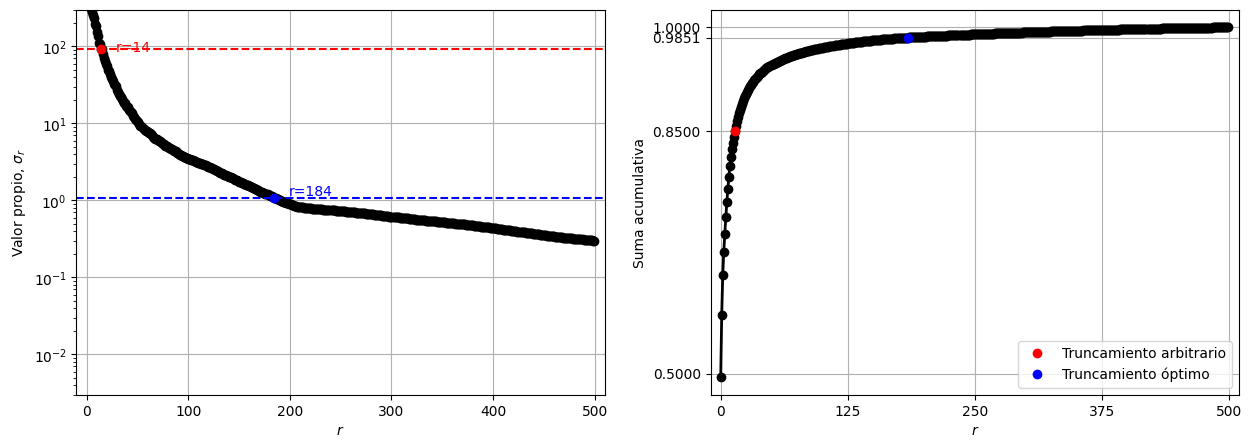

In [7]:
# Rank-r truncation
fig1,axs = plt.subplots(1,2,figsize=(15,5))

axs[0].semilogy(Sr,'-o', color='k')

axs[0].plot(r, Sr[r+1], 'ro')
axs[0].text(r+15, Sr[r]+2, f'r={r}', ha='left', va='center',color='r')
axs[0].axhline(y=Sr[r+1], color='r', linestyle='--')

axs[0].plot(roptimal, Sr[roptimal+1], 'bo')
axs[0].text(roptimal+15, Sr[roptimal]+0.2, f'r={roptimal}', ha='left', va='center',color='b')
axs[0].axhline(y=Sr[roptimal+1], color='b', linestyle ='--')

axs[0].set_xlim((-10,X.shape[1]+10))
axs[0].set_ylim((0.003,300))
axs[0].set_ylabel(r'Valor propio, $\sigma_r$')
axs[0].set_xlabel(r'$r$')

axs[0].grid()

axs[1].plot(cdS,'-o',color='k',linewidth=2)
axs[1].plot(r, cdS[r], 'ro',label='Truncamiento arbitrario')
axs[1].plot(roptimal, cdS[roptimal], 'bo',label='Truncamiento óptimo')
axs[1].set_xticks(np.array([0, 125, 250, 375, 500]))
axs[1].set_yticks(np.array([0.5, cdS[r], cdS[roptimal], 1]))
axs[1].set_xlim((-10,X.shape[1]+10))
axs[1].set_ylabel(r'Suma acumulativa')
axs[1].set_xlabel(r'$r$')
axs[1].legend()

axs[1].grid()

plt.show()

In [8]:
alpha = Vr14 @ X.T
print(f"Dimensiones de alpha = {alpha.shape} (r, tiempo)")

Dimensiones de alpha = (15, 11953) (r, tiempo)


In [9]:
# Guardado de matriz de cambio de base
file_path = r'../datos/Vr14.mat'
data = {'Vr14': Vr14}


#scipy.io.savemat(file_path, data)